In [1]:
from hepmc.core.densities.qcd import ee_qq_ng, export_hepmc
from hepmc.core.phase_space.rambo import RamboOnDiet
from hepmc.core.densities.sarge import Sarge
from hepmc.core.phase_space.mapping import MappedDensity
from hepmc.core.markov.metropolis import DefaultMetropolis
from hepmc.core.hamiltonian.hmc import HamiltonianUpdate
from hepmc.core.integration.importance import ImportanceMC
from hepmc import surrogate
from hepmc.core.densities.gaussian import Gaussian
from hepmc.core.sampling import Sample
from hepmc.core.hamiltonian.spherical_hmc import StaticSphericalHMC
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
eeqqg = ee_qq_ng(1, 100., 5., .3)
rambo_mapping = RamboOnDiet(100., 3)
mapped = MappedDensity(eeqqg, rambo_mapping)
sarge = Sarge(2, 3, 100.)

In [50]:
sarge_sample, _, _ = ImportanceMC(sarge).integrate(eeqqg, 10000)
sarge_sample_df = pd.DataFrame(sarge_sample.data)

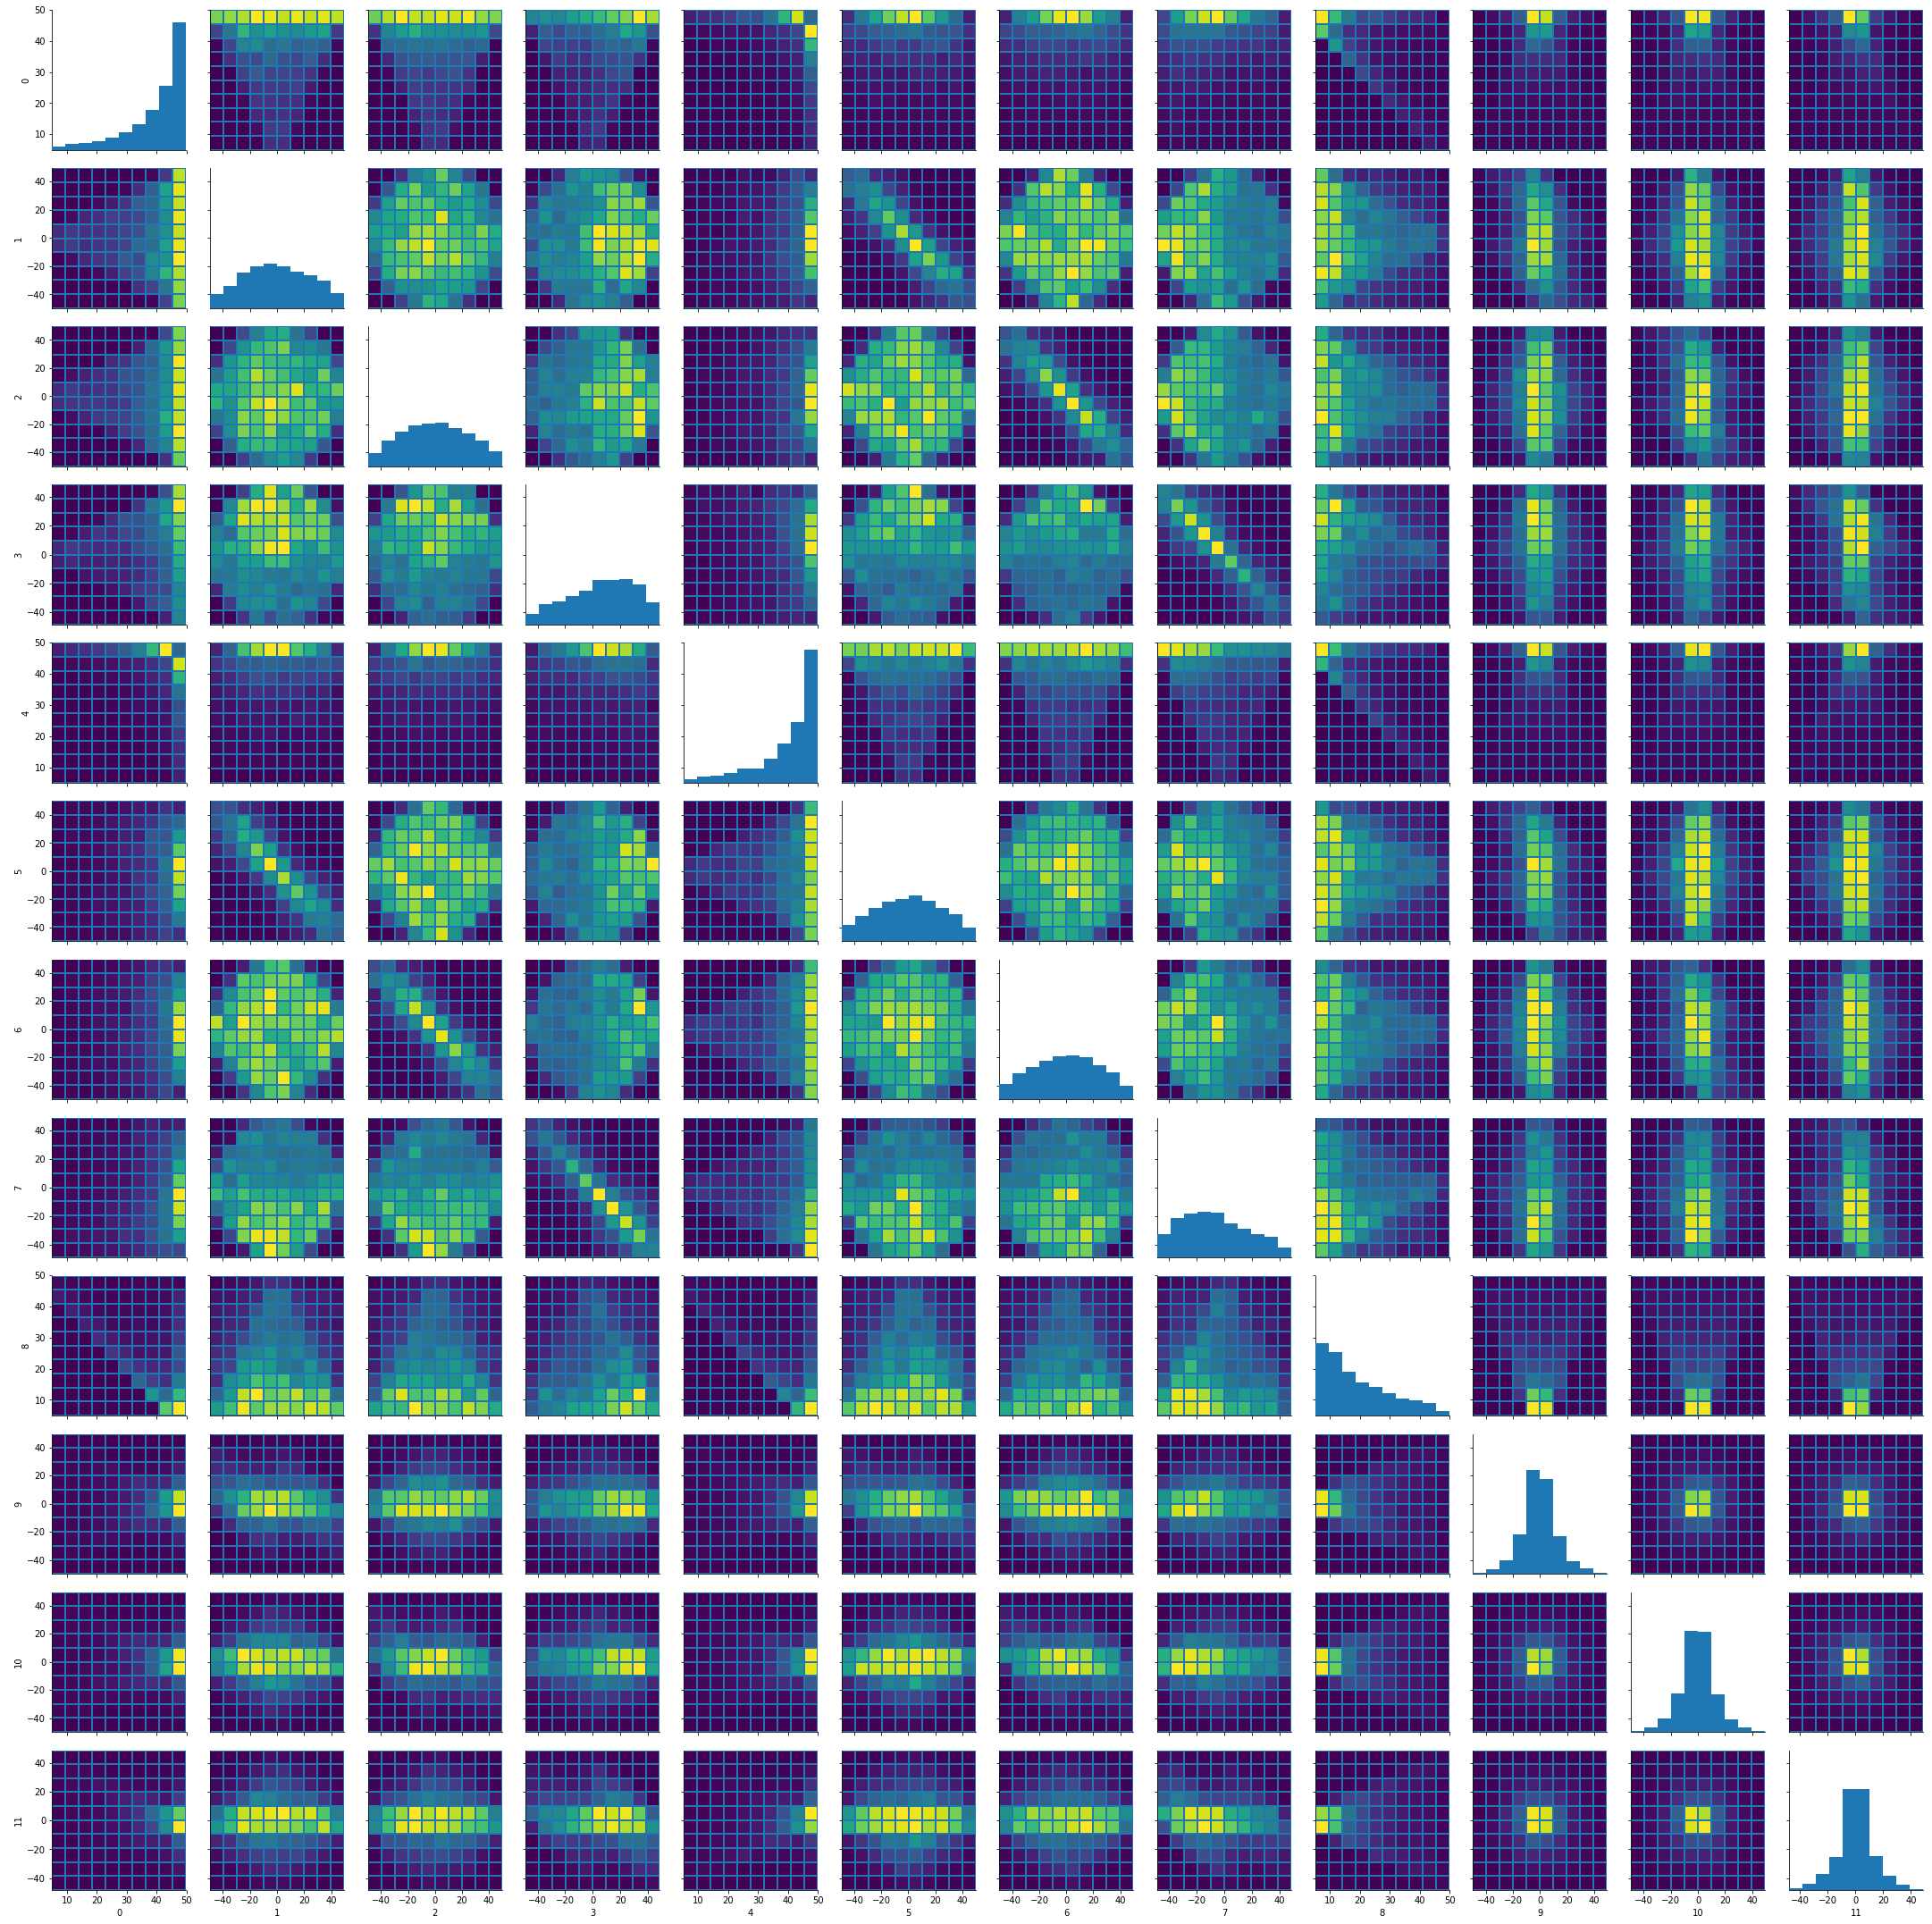

In [51]:
f = sns.PairGrid(sarge_sample_df)
f = f.map_diag(plt.hist, weights=sarge_sample.weights, bins=10)
f = f.map_offdiag(plt.hist2d, weights=sarge_sample.weights, bins=10)

In [41]:
xvals = np.random.random((100000, 5))
fvals = mapped.pdf(xvals)
#zeros = xvals[np.where(fvals==0)]
#log_vals = -np.ma.log(fvals)
#xvals = xvals[~log_vals.mask]
#log_vals = log_vals[~log_vals.mask]

In [ ]:
log_vals

In [43]:
xvals_df = pd.DataFrame(xvals)
#zeros_df = pd.DataFrame(zeros)

In [ ]:
f = sns.PairGrid(zeros_df)
f = f.map_diag(plt.hist)
f = f.map_offdiag(plt.hist2d)

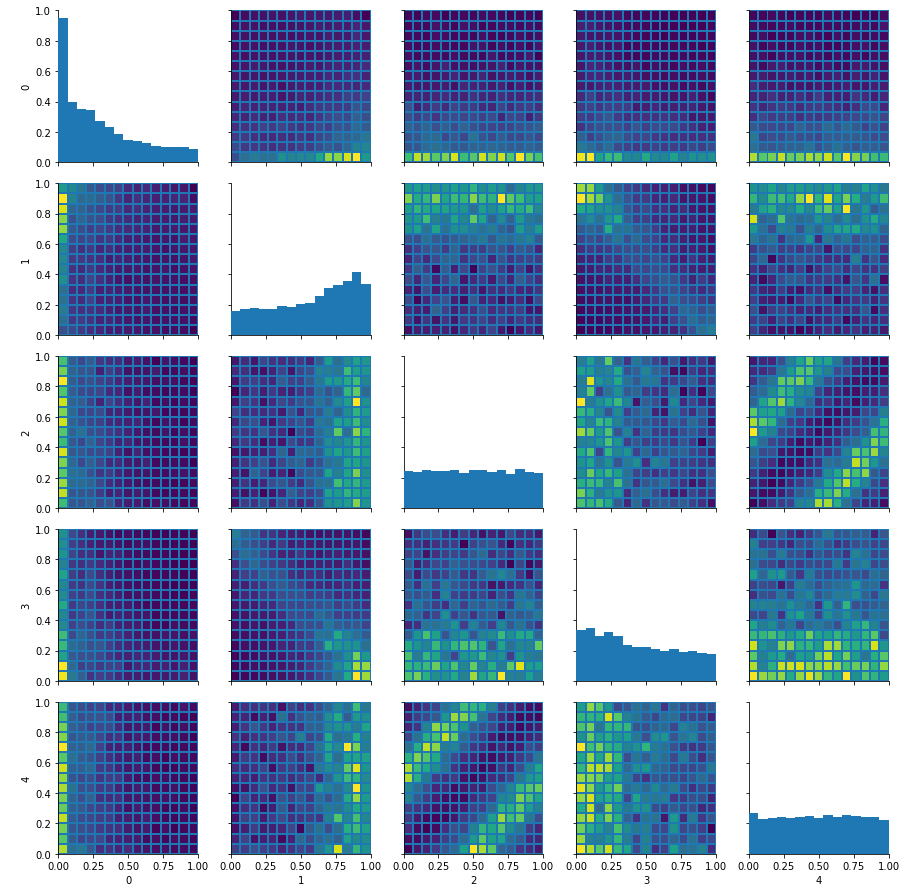

In [44]:
g = sns.PairGrid(xvals_df)
g = g.map_diag(plt.hist, weights=fvals, bins=15)
g = g.map_offdiag(plt.hist2d, weights=fvals, bins=15)

In [34]:
nodes = 300
nlearn = 100000

xvals = np.random.random((nlearn, 5))
fvals = mapped.pdf(xvals)

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(5)
#log_vals = -np.ma.log(fvals)
#xvals = xvals[~log_vals.mask]
#log_vals = log_vals[~log_vals.mask]
# train
%time params = basis.extreme_learning_train(xvals, fvals, nodes)

# surrogate
def surrogate_fn(xs):
    return basis.eval(*params, xs)[0]

# surrogate gradient
def surrogate_gradient(xs):
    return basis.eval_gradient(*params, xs)
#mapped.pot_gradient = surrogate_gradient
#mapped.pdf_gradient = surrogate_gradient

def pot_gradient(xs):
    pdf = mapped.pdf(xs)
    if pdf == 0:
        return np.full(5, np.inf)
    
    return -surrogate_gradient(xs) / pdf

mapped.pot_gradient = pot_gradient

CPU times: user 22.5 s, sys: 4.2 s, total: 26.7 s
Wall time: 10.3 s


In [ ]:
surrogate_vals = np.array([surrogate_fn(val) for val in xvals_df.values])

In [ ]:
h = sns.PairGrid(xvals_df)
h = h.map_diag(plt.hist, weights=surrogate_vals, bins=15)
h = h.map_offdiag(plt.hist2d, weights=surrogate_vals, bins=15)

In [ ]:
sarge_vals = sarge.pdf(rambo_mapping.map(xvals_df.values))

In [ ]:
np.partition(sarge_vals, -10)[-10:]

In [ ]:
np.argpartition(sarge_vals, -10)[-10:]

In [ ]:
rambo_mapping.map(xvals_df.values[60625])

In [ ]:
# mask th two biggest values
max_vals = np.argpartition(sarge_vals, -2)[-2:]
mask = np.ones(len(sarge_vals), dtype=bool)
mask[max_vals] = 0
masked_df = pd.DataFrame(xvals_df.values[mask])
masked_sarge_vals = sarge_vals[mask]

In [ ]:
i = sns.PairGrid(masked_df)
i = i.map_diag(plt.hist, weights=masked_sarge_vals, bins=15)
i = i.map_offdiag(plt.hist2d, weights=masked_sarge_vals, bins=15)

In [ ]:
sarge_sample, _, _ = ImportanceMC(sarge).integrate(eeqqg, 10000)

In [52]:
sarge_sample_df = pd.DataFrame(rambo_mapping.map_inverse(sarge_sample.data))

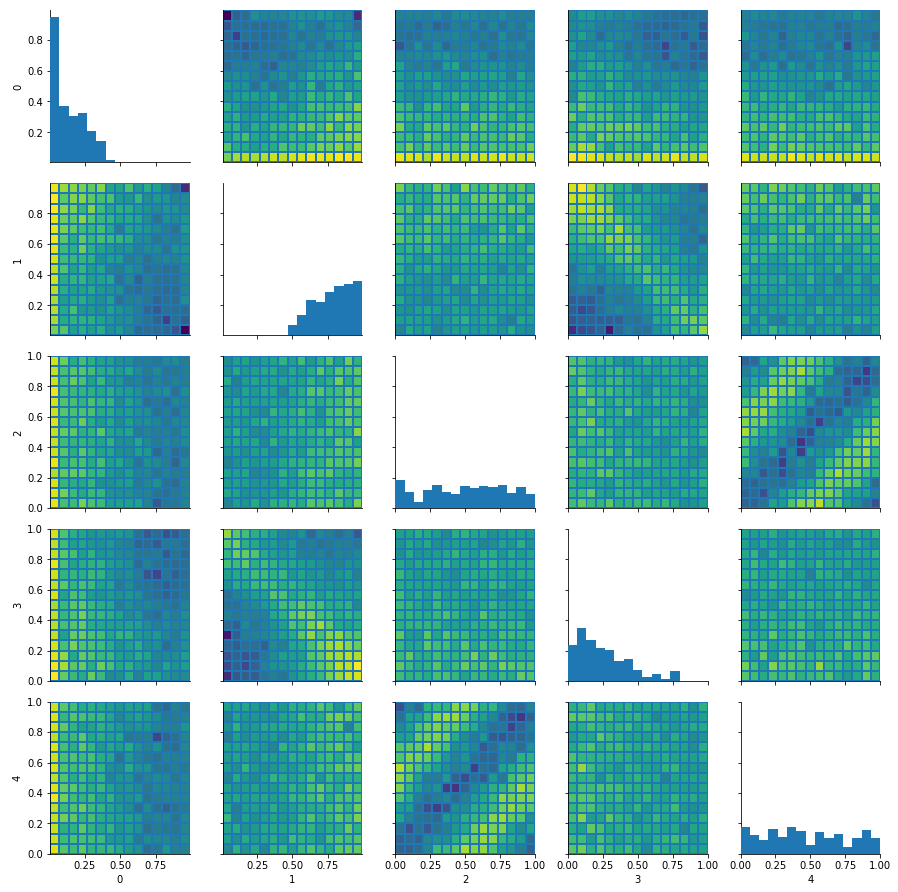

In [56]:
from matplotlib.colors import LogNorm
j = sns.PairGrid(sarge_sample_df)
j = j.map_diag(plt.hist, bins=15, weights=sarge_sample.weights, log=True)
j = j.map_offdiag(plt.hist2d, bins=15, weights=sarge_sample.weights, norm=LogNorm())

In [ ]:
rambo_mapping.map_inverse(np.median(sarge_sample.data, axis=0))

In [38]:
start = np.random.random(5)
#start = rambo_mapping.map_inverse(sarge_sample.data[-1])[0]
print('start:', start)
print('pdf:', mapped.pdf(start))
print('pot:', mapped.pot(start))
print('pot_grad:', mapped.pot_gradient(start))
sampler = StaticSphericalHMC(mapped, .005, .1, 2, 10)
%time hmc_sample = sampler.sample(15000, start)

start: [0.53552526 0.50862815 0.40250443 0.22043847 0.76072398]
pdf: [56.325857]
pot: [14.8095635]
pot_grad: [[ 13.56530549 -17.32225126  15.23320984  -9.2540115   -9.05109047]]
Event 1	(batch acceptance rate: 0.000000)
Event 2	(batch acceptance rate: 0.000000)	max sequence length: 3
Event 3	(batch acceptance rate: 0.000000)	max sequence length: 4
Event 4	(batch acceptance rate: 0.000000)	max sequence length: 5
Event 5	(batch acceptance rate: 0.000000)	max sequence length: 6
Event 6	(batch acceptance rate: 0.166667)	max sequence length: 6
Event 7	(batch acceptance rate: 0.142857)	max sequence length: 6
Event 8	(batch acceptance rate: 0.250000)	max sequence length: 6
Event 9	(batch acceptance rate: 0.222222)	max sequence length: 6
Event 10	(batch acceptance rate: 0.200000)	max sequence length: 6
Event 20	(batch acceptance rate: 0.350000)	max sequence length: 6
Event 30	(batch acceptance rate: 0.433333)	max sequence length: 6
Event 40	(batch acceptance rate: 0.375000)	max sequence length

In [39]:
hmc_sample = Sample(data=hmc_sample.data[5000:], weights=hmc_sample.weights[5000:])
hmc_sample_df = pd.DataFrame(hmc_sample.data)

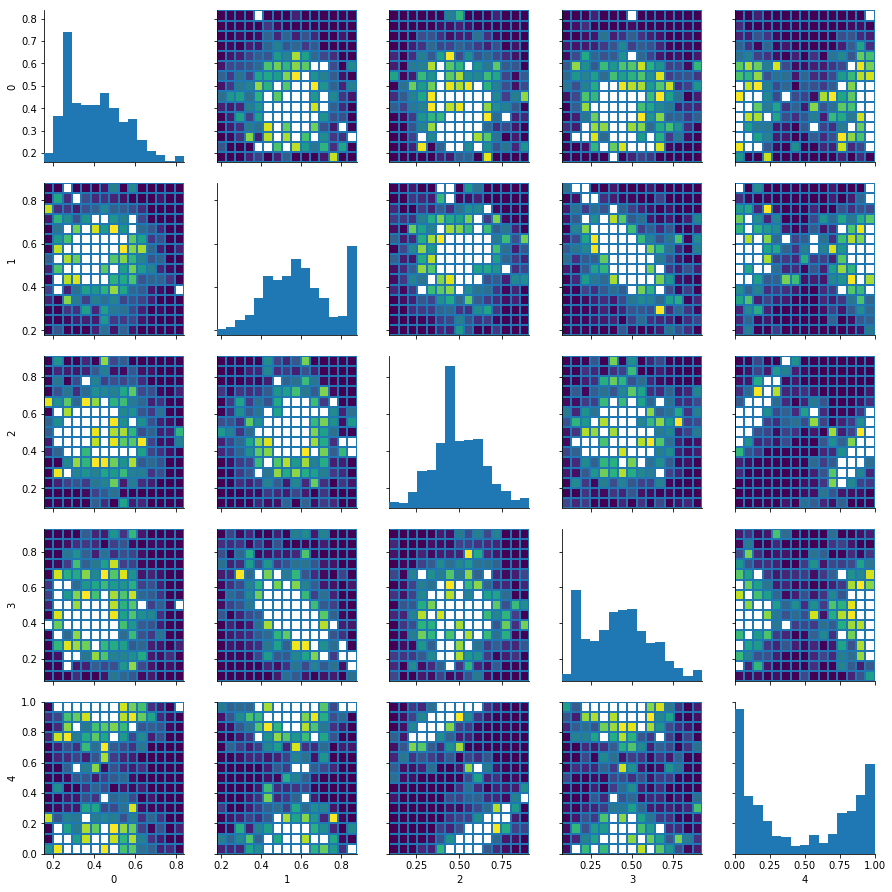

In [40]:
k = sns.PairGrid(hmc_sample_df)
k = k.map_diag(plt.hist, bins=15, weights=hmc_sample.weights)
k = k.map_offdiag(plt.hist2d, bins=15, weights=hmc_sample.weights, cmax=.5)

In [ ]:
# Surrogate HMC without spherical augmentation
start = np.random.random(5)
print('start:', start)
print('pot:', mapped.pot(start))

sampler = HamiltonianUpdate(mapped, Gaussian(5, 1.), 30, .001)
%time hmc_sample = sampler.sample(15000, start)

In [ ]:
mapped_hmc_sample = Sample(data=rambo_mapping.map(hmc_sample.data[5000:]), weights=np.full(10000, 1/10000))
export_hepmc(100., mapped_hmc_sample, "../samples/qcd/2-3/hmc.hepmc")

In [ ]:
hmc_sample_df = pd.DataFrame(hmc_sample.data[5000:])

In [ ]:
h = sns.PairGrid(hmc_sample_df)
h = h.map_diag(plt.hist)
h = h.map_offdiag(plt.hist2d)

In [ ]:
start = np.random.random(5)
sampler = StaticSphericalHMC(mapped, 3., 3., 4, 4)
%time spherical_sample = sampler.sample(15000, start)

In [ ]:
spherical_sample_df = pd.DataFrame(spherical_sample.data)

In [ ]:
i = sns.PairGrid(spherical_sample_df)
i = i.map_diag(plt.hist, weights=spherical_sample.weights)
i = i.map_offdiag(plt.hist2d, weights=spherical_sample.weights)